In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = '/home/mpgetz/repos/bee_mapping/data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

# Define the bounding box
bbox = [-125, 35, -66, 54] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(1000))  # For approximately 1000 points
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')


In [10]:
america_df = pd.DataFrame(land_coordinates, columns=['lat', 'lon'])

# america_df.to_csv('na_points.csv', index=False)

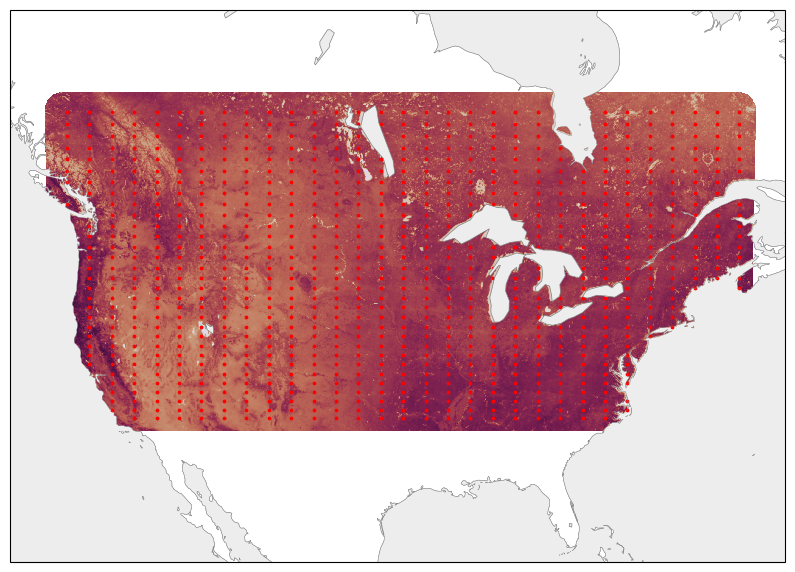

In [11]:

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([-130, -62, 24, 54])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/tifs/namerica_NDVI.tif'
with rasterio.open(ndvi_tiff_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)
    ax.imshow(ndvi_data, origin='upper', transform=ccrs.PlateCarree(), extent=[-127, -64.5, 34, 55], cmap='twilight_shifted')

# Plot the points
lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)


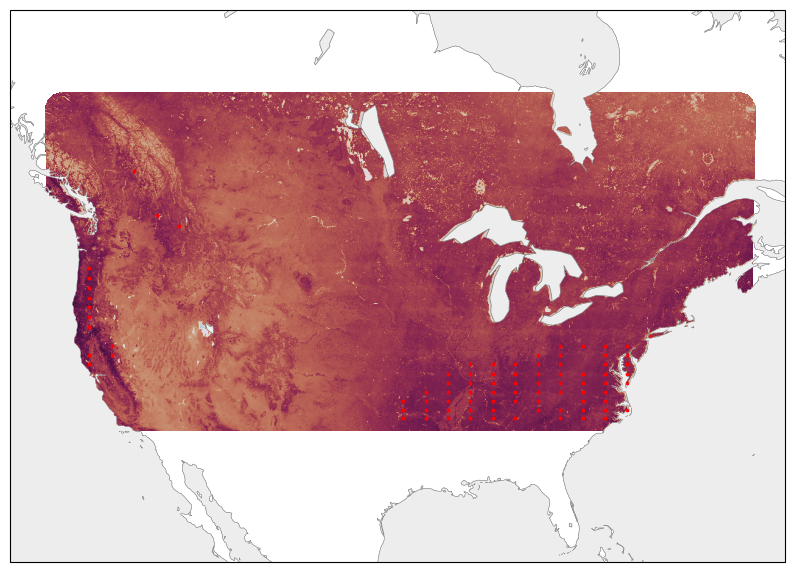

In [20]:
test_points = pd.read_csv('data/csv/test_points.csv')

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([-130, -62, 24, 54])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/tifs/namerica_NDVI.tif'
with rasterio.open(ndvi_tiff_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)
    ax.imshow(ndvi_data, origin='upper', transform=ccrs.PlateCarree(), extent=[-127, -64.5, 34, 55], cmap='twilight_shifted')


ax.scatter(test_points['lon'], test_points['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=3)

In [12]:
import os
from concurrent.futures import ThreadPoolExecutor


def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None


In [13]:
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  # Read the entire file into an array
        america_df[column_name] = america_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        america_df[column_name] = america_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

america_df.to_csv('america_bioclim_ndvi.csv')

['/home/mpgetz/repos/bee_mapping/data/tifs/namerica_NDVI.tif']
Processing: ndvi

['wc2.1_30s_bio_11.tif', 'wc2.1_30s_bio_3.tif', 'wc2.1_30s_bio_9.tif', 'wc2.1_30s_bio_13.tif', 'wc2.1_30s_bio_5.tif', 'wc2.1_30s_bio_6.tif', 'wc2.1_30s_elev.tif', 'wc2.1_30s_bio_17.tif', 'wc2.1_30s_bio_10.tif', 'wc2.1_30s_bio_2.tif', 'wc2.1_30s_bio_15.tif', 'wc2.1_30s_bio_12.tif', 'wc2.1_30s_bio_1.tif', 'wc2.1_30s_bio_16.tif', 'wc2.1_30s_bio_8.tif', 'wc2.1_30s_bio_4.tif', 'wc2.1_30s_bio_19.tif', 'wc2.1_30s_bio_7.tif', 'wc2.1_30s_bio_14.tif', 'wc2.1_30s_bio_18.tif']
Processing: bio_11

Processing: bio_3

Processing: bio_9

Processing: bio_13

Processing: bio_5

Processing: bio_6

Processing: elev

Processing: bio_17

Processing: bio_10

Processing: bio_2

Processing: bio_15

Processing: bio_12

Processing: bio_1

Processing: bio_16

Processing: bio_8

Processing: bio_4

Processing: bio_19

Processing: bio_7

Processing: bio_14

Processing: bio_18



# Sahara

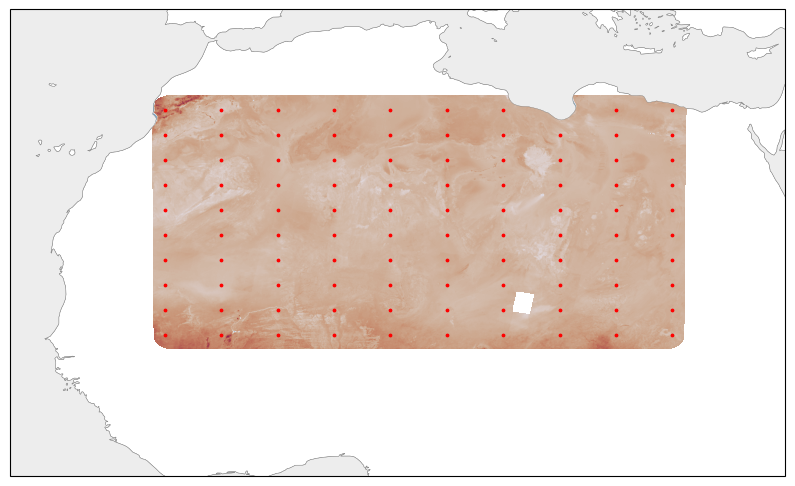

In [4]:
# Define the bounding box
bbox = [-9, 15, 27, 31] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(100))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
sahara_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = sahara_gdf[sahara_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
sahara_coordinates = [(point.y, point.x) for point in land_points['geometry']]



fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-20, 35, 5, 35])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/tifs/sahara_NDVI.tif'
with rasterio.open(ndvi_tiff_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)
    ax.imshow(ndvi_data, origin='upper', transform=ccrs.PlateCarree(), extent=[-10, 28, 14, 32], cmap='twilight_shifted')


# Plot the points
lats, lons = zip(*sahara_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)


In [5]:
sahara_df = pd.DataFrame(sahara_coordinates, columns=['lat', 'lon'])

# sahara_df.to_csv('sahara_points.csv', index=False)

In [6]:
## SAHARA NDVI
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  # Read the entire file into an array
        sahara_df[column_name] = sahara_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        sahara_df[column_name] = sahara_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

sahara_df.to_csv('sahara_bioclim_ndvi.csv')

['/home/mpgetz/repos/bee_mapping/data/tifs/sahara_NDVI.tif']
Processing: ndvi



# Siberia

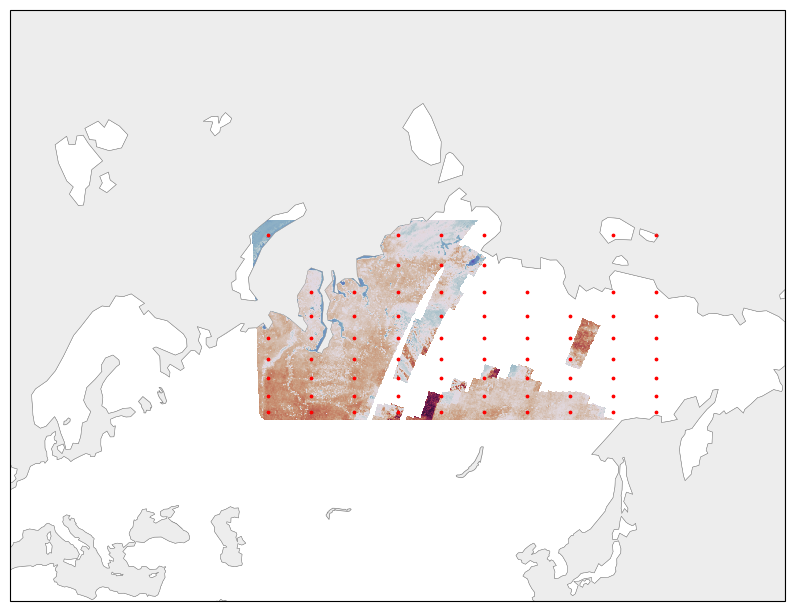

In [14]:
# Define the bounding box
bbox = [60, 60, 150, 77] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(100))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
siberia_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = siberia_gdf[siberia_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
siberia_coordinates = [(point.y, point.x) for point in land_points['geometry']]


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([0, 180, 30, 75])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/tifs/siberia_NDVI.tif'
with rasterio.open(ndvi_tiff_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)
    ax.imshow(ndvi_data, origin='upper', transform=ccrs.PlateCarree(), extent=[56, 153.5, 59, 76], cmap='twilight_shifted')


# Plot the points
lats, lons = zip(*siberia_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)

In [15]:
siberia_df = pd.DataFrame(siberia_coordinates, columns=['lat', 'lon'])

# siberia_df.to_csv('siberia_points.csv', index=False)

In [16]:
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  # Read the entire file into an array
        siberia_df[column_name] = siberia_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        siberia_df[column_name] = siberia_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

siberia_df.to_csv('siberia_bioclim_ndvi.csv')

['/home/mpgetz/repos/bee_mapping/data/tifs/siberia_NDVI.tif']
Processing: ndvi

['wc2.1_30s_bio_11.tif', 'wc2.1_30s_bio_3.tif', 'wc2.1_30s_bio_9.tif', 'wc2.1_30s_bio_13.tif', 'wc2.1_30s_bio_5.tif', 'wc2.1_30s_bio_6.tif', 'wc2.1_30s_elev.tif', 'wc2.1_30s_bio_17.tif', 'wc2.1_30s_bio_10.tif', 'wc2.1_30s_bio_2.tif', 'wc2.1_30s_bio_15.tif', 'wc2.1_30s_bio_12.tif', 'wc2.1_30s_bio_1.tif', 'wc2.1_30s_bio_16.tif', 'wc2.1_30s_bio_8.tif', 'wc2.1_30s_bio_4.tif', 'wc2.1_30s_bio_19.tif', 'wc2.1_30s_bio_7.tif', 'wc2.1_30s_bio_14.tif', 'wc2.1_30s_bio_18.tif']
Processing: bio_11

Processing: bio_3

Processing: bio_9

Processing: bio_13

Processing: bio_5

Processing: bio_6

Processing: elev

Processing: bio_17

Processing: bio_10

Processing: bio_2

Processing: bio_15

Processing: bio_12

Processing: bio_1

Processing: bio_16

Processing: bio_8

Processing: bio_4

Processing: bio_19

Processing: bio_7

Processing: bio_14

Processing: bio_18

